In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dill
import seaborn as sns

from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
import xgboost

sns.set()

In [2]:
# Load previously saved preprocessed data splits
with open('../results/data_split_nsr.pkl', 'rb') as file:
    data_split_nsr = dill.load(file)

ftr_names = np.array(['L2 prox gbar', 'L5 prox gbar', 'L2 dist gbar', 'L5 dist gbar', 'Prox variance', 'Dist variance',
               'Prox mean time', 'Dist mean time'])

unit_list = ['Strength (nS)', 'Strength (nS)','Strength (nS)', 'Strength (nS)',
             'Time Var (ms^2)', 'Time Var (ms^2)', 'Time (ms)', 'Time (ms)']

In [3]:
results_dict = dict()
res_names = ['linear_regression', 'ridge_regression', 'kn_regression', 'xgb_regression']
regression_dict = {
    'linear_regression': LinearRegression,
    'ridge_regression': Ridge,
    'kn_regression': KNeighborsRegressor,
    'sv_regression': SVR,
    'xgb_regression': xgboost.XGBRegressor
}

for name in res_names:
    with open(f'../results/{name}_results.pkl', 'rb') as file:
        results_dict[name] = dill.load(file)

In [7]:
model_name = 'xgb_regression'
split_idx = 0
random_idx = 0

X_train = data_split_nsr[split_idx]['X_train']
X_test = data_split_nsr[split_idx]['X_test']
y_train, y_test = data_split_nsr[split_idx]['y_train'],  data_split_nsr[split_idx]['y_test']

reg = regression_dict[model_name]()
params = results_dict[model_name][split_idx][random_idx]['best_params']
reg.set_params(**params)
reg.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.03, max_delta_step=0,
             max_depth=10, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=0, subsample=0.66,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [6]:
import shap
shap.initjs() # required for visualizations later on
# create the explainer object with the random forest model
explainer = shap.TreeExplainer(reg)

# calculate shap values on the first 1000 points in the test
shap_values = explainer.shap_values(X_test[:1000,:])
print(np.shape(shap_values))

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


(1000, 8)


In [13]:
index = 100 # the index of the point to explain
print(explainer.expected_value) # we explain class 0 predictions
shap.force_plot(explainer.expected_value, shap_values[index], features = X_test[index,:],feature_names = ftr_names)

-3460.7053


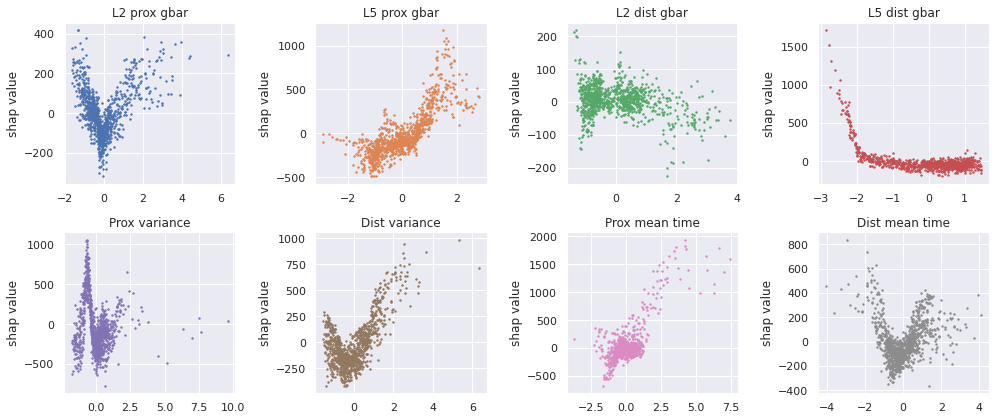

In [29]:
plt.figure(figsize=(14,6))
for idx, ftr in enumerate(ftr_names):
    plt.subplot(2, 4, idx+1)
    indx = np.argwhere(ftr_names==ftr)
    plt.scatter(X_test[:1000,indx],shap_values[:,indx], color=f'C{idx}', s=2)
    plt.ylabel('shap value')
    plt.title(ftr)
    plt.tight_layout()

plt.savefig('../figures/xgboost_shap.png')

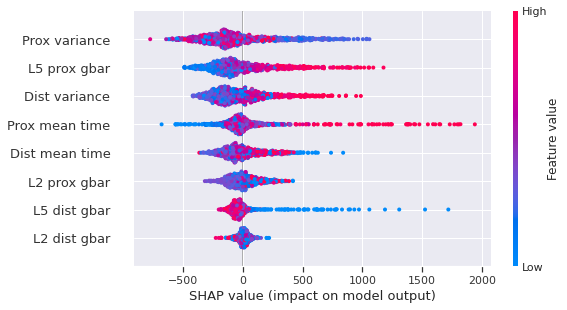

In [39]:
shap.summary_plot(shap_values, X_shap)